<a href="https://colab.research.google.com/github/Shradhs1802/sms_spam_detection/blob/main/Root2AIfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Report**

#I have with me a dataset, on which I have to perform the Exploratory Data Analysis and build a model on the same.

#The data seems to be from the Banking Sector. The sample size is 22,704. On first observation we find that the dataset has only two columns i.e. "Text" and "Target". It is also observed that there are 11 classes in the Target column. So we can say that it will be an example of Multiclass Text Data Classification. 

#SO let us start by importing the necessary libraries and uploading the dataset.
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

from textblob import TextBlob
import pickle


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# After downloading the necessary libraries, we need to load the dataset, but for that we need to first mount our Google drive where the dataset is present on our notebook and then upload the dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/root2ai - Data.csv')
data.head()

,Text,Target
0,reserve bank forming expert committee based in...,Blockchain
1,director could play role financial system,Blockchain
2,preliminary discuss secure transaction study r...,Blockchain
3,security indeed prove essential transforming f...,Blockchain
4,bank settlement normally take three days based...,Blockchain


#Lets look at the dataset info to see if everything is alright

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22704 entries, 0 to 22703
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    22701 non-null  object
 1   Target  22704 non-null  object
dtypes: object(2)
memory usage: 354.9+ KB


In [5]:
print(data.shape)

num_of_classes = len(data.Target.unique())
print(num_of_classes)

data.describe()

(22704, 2)
11


,Text,Target
count,22701,22704
unique,20986,11
top,billion,FinTech
freq,41,8551


#We can see in the above result that the text column has 22701 entries whereas the target column has 22704 entries. As we already know sample size is 22704, it means there are three null or NAN values in the Text column.

In [6]:
data.groupby('Target').describe()

Text  ...     
                 count  ... freq
Target                  ...     
Bigdata           2267  ...   27
Blockchain        1375  ...    4
Cyber Security    2640  ...   28
Data Security      347  ...    1
FinTech           8551  ...   17
Microservices      974  ...    5
Neobanks          1069  ...   11
Reg Tech          2206  ...   16
Robo Advising      737  ...    3
Stock Trading      787  ...    2
credit reporting  1748  ...    9

[11 rows x 4 columns]

# This table helps us in understanding the distribution of each class, the unique values in the texts, the most repeated words and their frequencies in each class. Lets see this pictographically.

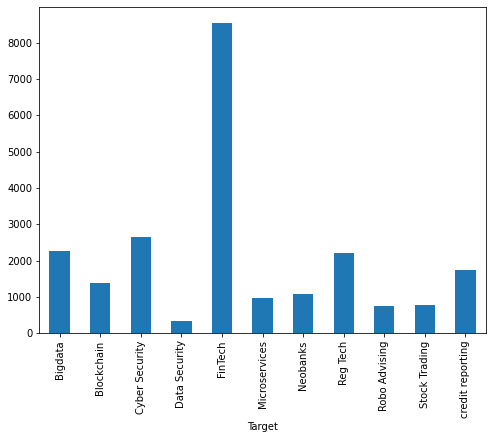

In [7]:
fig = plt.figure(figsize=(8,6))
data.groupby('Target').Text.count().plot.bar(ylim=0)
plt.show()

# We can clearly see from the graph that there is class imbalance and our model may be biased towards the class with maximum frequency.

# Lets see the top 10 text data

In [8]:
topMessages = data.groupby("Text")["Target"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)

,len,amax
Text,,
billion,41,credit reporting
para,31,FinTech
ncbi,27,Bigdata
retrieved october,21,Bigdata
versus,17,FinTech
perma,16,Reg Tech
corpusid,16,Bigdata
issn,16,Bigdata
data,15,credit reporting


In [9]:
data['length'] = data['Text'].str.len()

print (data.head())

                                                Text      Target  length
0  reserve bank forming expert committee based in...  Blockchain   157.0
1          director could play role financial system  Blockchain    41.0
2  preliminary discuss secure transaction study r...  Blockchain    61.0
3  security indeed prove essential transforming f...  Blockchain   109.0
4  bank settlement normally take three days based...  Blockchain   102.0


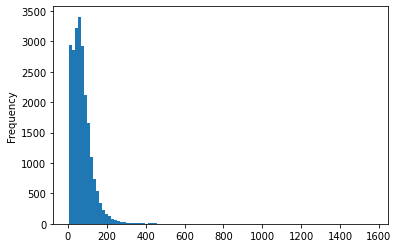

In [10]:
data.length.plot(bins=100, kind='hist')

#We can see here maximum texts contain number of words in the range of [0, 200].

#Lets convert Target class into numeric form

In [11]:
from io import StringIO
col = ['Text', 'Target']
data = data[col]
data = data[pd.notnull(data['Text'])]
data.columns = ['Text', 'Target']
data['category_id'] = data['Target'].factorize()[0]
category_id_data = data[['Target', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_data.values)
id_to_category = dict(category_id_data[['category_id', 'Target']].values)
data.head()

,Text,Target,category_id
0,reserve bank forming expert committee based in...,Blockchain,0
1,director could play role financial system,Blockchain,0
2,preliminary discuss secure transaction study r...,Blockchain,0
3,security indeed prove essential transforming f...,Blockchain,0
4,bank settlement normally take three days based...,Blockchain,0


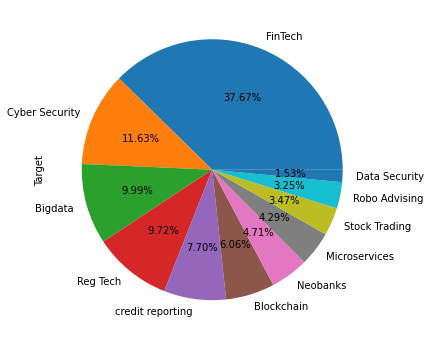

In [12]:
data['Target'].value_counts().plot(kind = 'pie',figsize = (6,6),autopct = "%1.2f%%")

plt.show()

#Word Vectorization

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(encoding='latin-1')
features = tfidf.fit_transform(data.Text).toarray()

features.shape

(22701, 11409)

In [14]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
y = data['category_id']

y

0         0
1         0
2         0
3         0
4         0
         ..
22699    10
22700    10
22701    10
22702    10
22703    10
Name: category_id, Length: 22701, dtype: int64

# Splitting the dataset into train and test datasets

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=42, test_size=0.2)

print("Training Data:",X_train.shape,y_train.shape )

print("Testing Data:", X_test.shape,y_test.shape)





Training Data: (18160, 11409) (18160,)
Testing Data: (4541, 11409) (4541,)


# Applying Multinomial Bayes Theorem to the dataset

In [26]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train,y_train)
y_pred = model.predict(X_test)
print("Accuracy = ", accuracy_score(y_test,y_pred))

Accuracy =  0.5316009689495705


# Let us see the Classification Report which gives us Precision, Recall, F1 Score and Support Values.

In [27]:
print(classification_report(y_test,y_pred,target_names =data['Target'].unique()))

                  precision    recall  f1-score   support

      Blockchain       0.89      0.06      0.12       259
         Bigdata       0.97      0.56      0.71       474
credit reporting       0.80      0.07      0.12       358
  Cyber Security       0.78      0.25      0.38       519
         FinTech       0.45      0.99      0.62      1725
   Microservices       1.00      0.02      0.04       181
        Neobanks       1.00      0.00      0.01       201
   Robo Advising       0.00      0.00      0.00       157
   Stock Trading       1.00      0.03      0.05       160
   Data Security       0.00      0.00      0.00        78
        Reg Tech       0.93      0.60      0.73       429

        accuracy                           0.53      4541
       macro avg       0.71      0.23      0.25      4541
    weighted avg       0.68      0.53      0.44      4541



# Lets check how effective our model is

In [28]:
check = pd.DataFrame({"actual":y_test,"predicted":y_pred})
check

,actual,predicted
9421,4,4
16923,5,4
10404,4,4
16056,4,4
1063,0,4
...,...,...
140,0,4
8588,4,4
15551,4,4
14307,4,4


# We can see that the dataset is biased towards '4' that is Fintech, this may be due to class imbalance. 

#**Model Selection**
#We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.
#We will benchmark the following four models:
#Logistic Regression
#(Multinomial) Naive Bayes
#Linear Support Vector Machine
#Random Forest

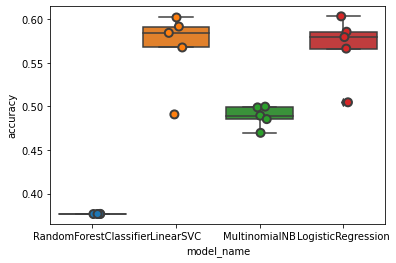

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [30]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.567291
LogisticRegression        0.567907
MultinomialNB             0.488658
RandomForestClassifier    0.376679
Name: accuracy, dtype: float64

#LinearSVC and Logistic Regression perform better than the other two classifiers, with a median accuracy of around 56%.
# The other two classifiers i.e. Multinomial NB and Random Forest are showing less than 50% accuracy on this dataset, whereas while applied individually Multinomial NB showed 53.16% accuracy.


#**Conclusion**
# 1. We can use our best model (LinearSVC) or Logistic Regression to solve the problem.
# 2. According to me the low accuracy is a cause of concern and I think this may be because of class imbalance. To overcome this we have to use Oversampling or Undersampling Technique. 
# 3. Maybe we should approach the dataset with Deep learning and solve the existing problem by using RNN-LSTM Model.